<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Classical Optimization*_ 

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the IBM Q Experience (QX), consult the [Quantum Experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Jay Gambetta, Antonio Mezzacapo, Ramis Movassagh, Kristan Temme

## Introduction



Many problems in finance and business are optimization problems. 

Optimization or combinatorial optimization means searching for an optimal solution in a finite or countably infinite set of potential solutions. Optimality is defined with respect to some criterion function, which is to be minimized or maximized, which is typically called the cost function. 

**Types of optimization problems**

Minimization: cost, distance, length of a traversal, weight, processing time, material, energy consumption, number of objects

Maximization: profit, value, output, return, yield, utility, efficiency, capacity, number of objects. 


Many optimization problem can be formulated in a generic form

\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & c(x) \\
& \text{subject to}
& & x \in S
\end{aligned}
\end{equation*}

where $x$ is a binary variable $0/1$, $c(x0$ is the cost function, and $S$ is the set of feasible solutions.

**Mapping this to quantum problem**

The total cost is a sum of the problem and the constraint. 

$$ C = - A c(x) - B (b-S x)\cdot (b-Sx) $$

where $A$ and $B$ are real positive input paramters that are chosen to weight the constraints to the problem.

To map this to qubits $x\rightarrow(z+1)/2$
Here we propose that we map the cost function of the problem to a Hamiltonian of the form

$$ H_\mathrm{Ising} = \alpha_i Z_i + \beta_{i,j} Z_jZ_i,$$

and the goal is to find the configuration that minimizes the energy.


Pseudo code

```
set the maximal control updates max_trials 
set initial controls u
loop through the max_trials
    prepare trial state |psi(u)> 
    
    Evaluate cost funtion C = <H> 
    
    Evaluate grad_u C (control update direction)
    
    update controls u -> u - grad_u C
    
    break if you find a good solution
    
return |<z|psi>|^2
```

The trial functions we propose using are of the form 

$$|\psi(\theta)\rangle  = [U_\mathrm{single}(\theta) U_\mathrm{entangler}]^m |+\rangle$$

where $U_\mathrm{entangler}$ is a function of cPhase gates, and $U_\mathrm{single}(\theta) = Y(\theta)^{\otimes n}$, where $n$ is the number of qubits and $m$ is the depth of the quantum circuit.

This can easily be extended: 

$$H = H_\mathrm{Ising}+ \gamma_{i,j,k}Z_kZ_jZ_i +... $$ 

Below we have shown how different problems can be mapped to the Ising model.

ADD

In [1]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import linalg as la

import sys
sys.path.append("../../")
# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram
import Qconfig

# import basic plot tools
from qiskit.basicplotter import plot_histogram

# import optimization tools
from tools.optimizationtools import trial_funtion_optimization, trial_funtion_optimization_no_meas
from tools.optimizationtools import cost_function, make_Hamiltonian

In [2]:
def SPSA_Minimization(Q_program, alpha, beta, n, device, shots, entangler_map, SPSA_parameters, max_trials, max_depth):
    
    # Initial controls and we do three different depths at once 
    theta = [] 
    for p in range(max_depth):
        theta.append(np.random.randn((p+1)*n))

    
    cost_save = np.zeros((max_depth, max_trials))
    for k in range(max_trials):
        
    
        #SPSA Paramaters
        a_spsa = float(SPSA_parameters[0])/np.power(k+1+SPSA_parameters[2], SPSA_parameters[1])
        c_spsa = float(SPSA_parameters[3])/np.power(k+1, SPSA_parameters[4])

        circuits = ["trial_circuit_plus_depth_1", "trial_circuit_minus_depth_1","trial_circuit_plus_depth_2", "trial_circuit_minus_depth_2","trial_circuit_plus_depth_3", "trial_circuit_minus_depth_3"]
        Delta = []
        theta_plus = []
        theta_minus = []
        trial_circuits = []
        for p in range(max_depth):
            m = p + 1
            Delta.append(2*np.random.randint(2,size = n*(m)) - 1) # \pm 1 random distribution 
            theta_plus.append(theta[p] + c_spsa*Delta[p])
            theta_minus.append(theta[p] - c_spsa*Delta[p])
            trial_circuits.append(trial_funtion_optimization(n,m,theta_plus[p],entangler_map))   
            trial_circuits.append(trial_funtion_optimization(n,m,theta_minus[p],entangler_map))
            Q_program.add_circuit(circuits[2*p], trial_circuits[2*p])
            Q_program.add_circuit(circuits[2*p+1], trial_circuits[2*p+1])  
        
        #running the program on the hardware
        Q_program.execute(circuits, device, shots)
    
        #estimating the next controls 
        for p in range(max_depth):
            cost_plus = cost_function(Q_program.get_counts(circuits[2*p]),n,alpha,beta)
            cost_minus = cost_function(Q_program.get_counts(circuits[2*p+1]),n,alpha,beta)
            g_spsa = (cost_plus-cost_minus)*Delta[p]/(2.0*c_spsa)
            theta[p] = theta[p] - a_spsa*g_spsa
            cost_save[p][k] =  (cost_plus+cost_minus)/2
        
        if k % 10 == 0:
            print('trial ' + str(k) + " of " + str(max_trials) + " cost " + str((cost_plus+cost_minus)/2))

    #finally run
    trial_circuits = []   
    circuits = ["trial_circuit_depth_1", "trial_circuit_depth_2","trial_circuit_depth_3"]
    for p in range(max_depth):
        trial_circuits.append(trial_funtion_optimization(n,p+1,theta[p],entangler_map))
        Q_program.add_circuit(circuits[p], trial_circuits[p])

    #execuation 
    Q_program.execute(circuits, device, shots)
    cost = [] 
    data_save = []
    
    for p in range(max_depth):
        cost.append(cost_function(Q_program.get_counts(circuits[p]),n,alpha,beta))
        data_save.append(Q_program.get_counts(circuits[p]))
                      
    return cost, data_save, cost_save
                         

In [52]:
def SPSA_Minimization_fast(Q_program, alpha, beta, n, entangler_map, SPSA_parameters, max_trials, max_depth):
    
    # Initial controls and we do three different depths at once 
    theta = [] 
    for p in range(max_depth):
        theta.append(np.random.randn((p+1)*n))

    H = make_Hamiltonian(n,alpha,beta)
    cost_save = np.zeros((max_depth, max_trials))
    for k in range(max_trials):
        
    
        #SPSA Paramaters
        a_spsa = float(SPSA_parameters[0])/np.power(k+1+SPSA_parameters[2], SPSA_parameters[1])
        c_spsa = float(SPSA_parameters[3])/np.power(k+1, SPSA_parameters[4])

        circuits = ["trial_circuit_plus_depth_1", "trial_circuit_minus_depth_1","trial_circuit_plus_depth_2", "trial_circuit_minus_depth_2","trial_circuit_plus_depth_3", "trial_circuit_minus_depth_3"]
        Delta = []
        theta_plus = []
        theta_minus = []
        trial_circuits = []
        for p in range(max_depth):
            m = p + 1
            Delta.append(2*np.random.randint(2,size = n*(m)) - 1) # \pm 1 random distribution 
            theta_plus.append(theta[p] + c_spsa*Delta[p])
            theta_minus.append(theta[p] - c_spsa*Delta[p])
            trial_circuits.append(trial_funtion_optimization_no_meas(n,m,theta_plus[p],entangler_map))   
            trial_circuits.append(trial_funtion_optimization_no_meas(n,m,theta_minus[p],entangler_map))
            Q_program.add_circuit(circuits[2*p], trial_circuits[2*p])
            Q_program.add_circuit(circuits[2*p+1], trial_circuits[2*p+1])  
        
        #running the program on the hardware
        Q_program.execute(circuits, 'local_qasm_simulator', 1)
    
        #estimating the next controls 
        for p in range(max_depth):
            cost_plus = (np.inner(np.conjugate(Q_program.get_data(circuits[2*p])['quantum_state']),np.dot(H,Q_program.get_data(circuits[2*p])['quantum_state']))).real
            cost_minus = (np.inner(np.conjugate(Q_program.get_data(circuits[2*p+1])['quantum_state']),np.dot(H,Q_program.get_data(circuits[2*p+1])['quantum_state']))).real
            g_spsa = (cost_plus-cost_minus)*Delta[p]/(2.0*c_spsa)
            theta[p] = theta[p] - a_spsa*g_spsa
            cost_save[p][k] =  (cost_plus+cost_minus)/2
        
        if k % 10 == 0:
            print('trial ' + str(k) + " of " + str(max_trials) + " cost " + str((cost_plus+cost_minus)/2))

    #finally run
    trial_circuits = []   
    circuits = ["trial_circuit_depth_1", "trial_circuit_depth_2","trial_circuit_depth_3"]
    for p in range(max_depth):
        trial_circuits.append(trial_funtion_optimization(n,p+1,theta[p],entangler_map))
        Q_program.add_circuit(circuits[p], trial_circuits[p])

    #execuation 
    Q_program.execute(circuits, 'local_qasm_simulator', 1024)
    cost = [] 
    data_save = []
    
    for p in range(max_depth):
        cost.append(cost_function(Q_program.get_counts(circuits[p]),n,alpha,beta))
        data_save.append(Q_program.get_counts(circuits[p]))
                      
    return cost, data_save, cost_save
                         

Enter the cost function below that you would like to minimize.

* [Max Cut](#sectionmaxcut)
 * [Two Qubits](#sectionmaxcuttwo)
 * [Three Qubits](#sectionmaxcutthree)
 * [Four Qubits](#sectionmaxcutfour)
 * [Ten Qubits](#sectionmaxcutten)

## Max Cut<a id='sectionmaxcut'></a>

Given a finite graph, color the vertices blue (X) and red (0) such that the number of edges between a blue vertex and a red vertex is as large as possible. 

### Two Qubits<a id='sectionmaxcuttwo'></a>

    Graph:   Q --- Q
    
The ground state is degenerate and is either $|01\rangle$ (X---0) and $|10\rangle$ (0-X).

In [3]:
# number of qubits
n=2 

# cost function H = alpha_i z_i + beta_ij z_i z_j
alpha = np.zeros(n)
beta = np.zeros((n, n))
beta[0, 1] = 1

In [4]:
#Setting up a quantum program and connecting to the Quantum Experience API
Q_program = QuantumProgram()
# set the APIToken and API url
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"])

True

In [5]:
#Making the Hamiltonian in its full form
H = make_Hamiltonian(n,alpha,beta)
print(H)

#geting the lowest eigenvalue and egienvector
w, v = la.eigh(H, eigvals=(0, 0))
print("Eigenvalue is %f and the state is" %(w))
print(v)

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]
Eigenvalue is -1.000000 and the state is
[[ 0.+0.j]
 [ 0.+0.j]
 [ 1.+0.j]
 [ 0.+0.j]]


In [6]:
# Quantum circuit parameters
device = 'local_qasm_simulator' # the device to run on
shots = 8192    # the number of shots in the experiment. 
entangler_map = {0: [1]} # the map of two-qubit gates with control at key and target at values

# Numerical parameters 
SPSA_parameters = np.array([.3,0.602,0,.1,0.101]) #[a, alpha, A, c, gamma]
max_trials = 100;
max_depth = 3

cost, data_save, cost_save = SPSA_Minimization(Q_program, alpha, beta, n, device, shots, entangler_map, SPSA_parameters, max_trials, max_depth)

print('m = 1 ' + str(cost[0]) + ' m = 2 ' + str(cost[1]) + 'm = 3 ' + str(cost[2]))

trial 0 of 100 cost 0.849975585938
trial 10 of 100 cost -0.18505859375
trial 20 of 100 cost -0.723754882812
trial 30 of 100 cost -0.875366210938
trial 40 of 100 cost -0.939086914062
trial 50 of 100 cost -0.974853515625
trial 60 of 100 cost -0.993408203125
trial 70 of 100 cost -0.993896484375
trial 80 of 100 cost -0.997436523438
trial 90 of 100 cost -0.9990234375
m = 1 -1.0 m = 2 -0.982421875m = 3 -1.0


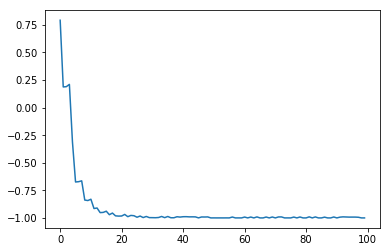

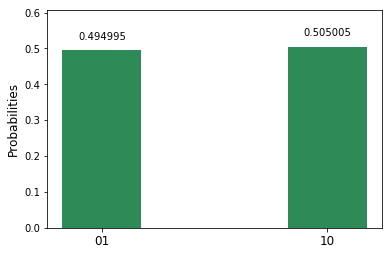

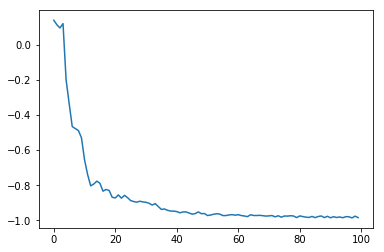

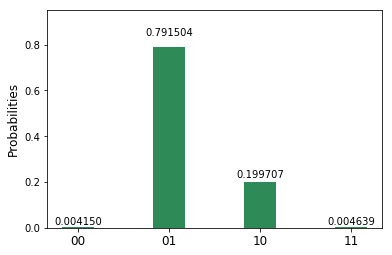

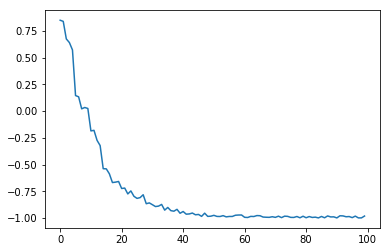

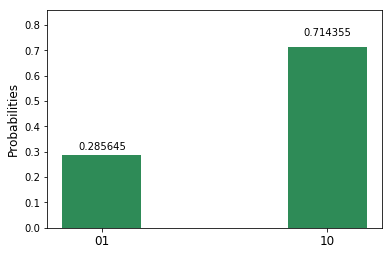

In [7]:
# plotting data
plt.plot(range(max_trials), cost_save[0])
plot_histogram(data_save[0])

plt.plot(range(max_trials), cost_save[1])
plot_histogram(data_save[1])

plt.plot(range(max_trials), cost_save[2])
plot_histogram(data_save[2])

### Three Qubits<a id='sectionmaxcutthree'></a>

    Graph:   
               X 
             /   \
            X --- X
            
The ground state is 6 fold degenerate and is either $|100\rangle$, $|010\rangle$, $|001\rangle$, $|110\rangle$, $|011\rangle$, and $|101\rangle$.

In [8]:
n = 3 

# cost function H = alpha_i z_i + beta_ij z_i z_j
alpha = np.zeros(n)
beta = np.zeros((n, n))
beta[0, 1] = 1
beta[0, 2] = 1
beta[1, 2] = 1

In [9]:
#Setting up a quantum program and connecting to the Quantum Experience API
Q_program = QuantumProgram()
# set the APIToken and API url
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"])

True

In [10]:
#Making the Hamiltonian in its full form
H = make_Hamiltonian(n,alpha,beta)
print(H)

#geting the lowest eigenvalue and egienvector
w, v = la.eigh(H, eigvals=(0, 0))
print("Eigenvalue is %f and the state is" %(w))
print(v)

[[ 3.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  3.+0.j]]
Eigenvalue is -1.000000 and the state is
[[ 0.+0.j]
 [ 0.+0.j]
 [ 0.+0.j]
 [ 0.+0.j]
 [ 0.+0.j]
 [ 0.+0.j]
 [ 1.+0.j]
 [ 0.+0.j]]


In [11]:
# Quantum circuit parameters
device = 'local_qasm_simulator' # the device to run on
shots = 8192    # the number of shots in the experiment. 
entangler_map = {0: [1], 1: [2]} # the map of two-qubit gates with control at key and target at values

# Numerical parameters 
SPSA_parameters = np.array([.3,0.602,0,.1,0.101]) #[a, alpha, A, c, gamma]
max_trials = 100;
max_depth = 3

cost, data_save, cost_save = SPSA_Minimization(Q_program, alpha, beta, n, device, shots, entangler_map, SPSA_parameters, max_trials, max_depth)

print('m = 1 ' + str(cost[0]) + ' m = 2 ' + str(cost[1]) + 'm = 3 ' + str(cost[2]))

trial 0 of 100 cost 0.44677734375
trial 10 of 100 cost -0.97412109375
trial 20 of 100 cost -0.983154296875
trial 30 of 100 cost -0.97021484375
trial 40 of 100 cost -0.9892578125
trial 50 of 100 cost -0.9912109375
trial 60 of 100 cost -0.99462890625
trial 70 of 100 cost -0.983154296875
trial 80 of 100 cost -0.995849609375
trial 90 of 100 cost -0.990966796875
m = 1 -1.0 m = 2 -0.99951171875m = 3 -0.998046875


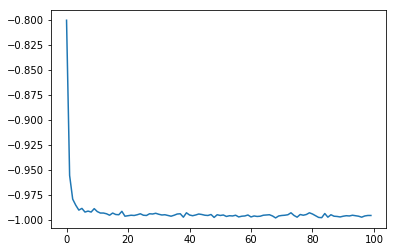

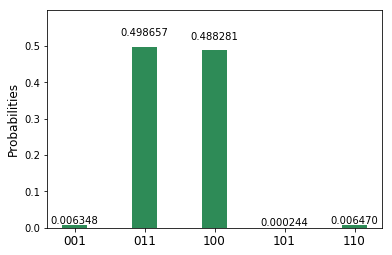

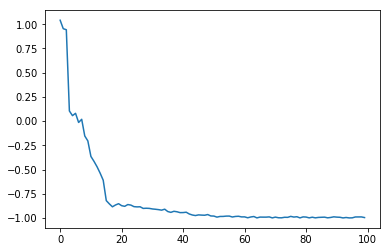

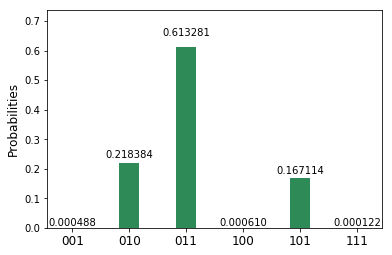

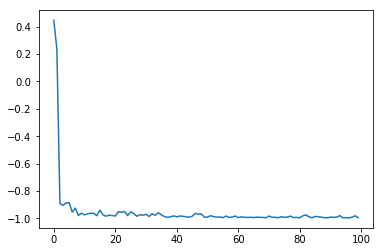

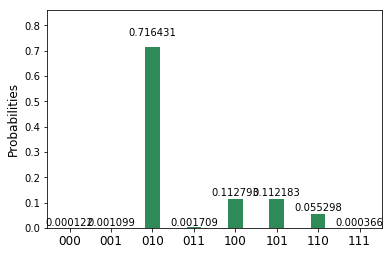

In [12]:
# plotting data
plt.plot(range(max_trials), cost_save[0])
plot_histogram(data_save[0])

plt.plot(range(max_trials), cost_save[1])
plot_histogram(data_save[1])

plt.plot(range(max_trials), cost_save[2])
plot_histogram(data_save[2])

## Four Qubits <a id='sectionmaxcutfour'></a>

    Graph:   
             X---X 
             | \ |
             X---X
           
The ground state is degenerate and is either $|100\rangle$, $|010\rangle$ and $|001\rangle$.

In [13]:
# cost function H = alpha_i z_i + beta_ij z_i z_j
n =4
alpha = np.zeros(n)
beta = np.zeros((n, n))
beta[0, 1] = 1
beta[0, 2] = 1
beta[1, 2] = 1
beta[1, 3] = 1
beta[2, 3] = 1

In [ ]:
#Setting up a quantum program and connecting to the Quantum Experience API
Q_program = QuantumProgram()
# set the APIToken and API url
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"])

In [14]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and egienvector
H = make_Hamiltonian(n,alpha,beta)
w, v = la.eigh(H, eigvals=(0, 1))
print(w)
v

[-3. -3.]


array([[ 0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j],
       [ 1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j],
       [ 0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j]])

In [15]:
# Quantum circuit parameters
device = 'local_qasm_simulator' # the device to run on
shots = 8192    # the number of shots in the experiment. 
entangler_map = {0: [1], 1: [2], 2: [3]} # the map of two-qubit gates with control at key and target at values

# Numerical parameters 
SPSA_parameters = np.array([.3,0.602,0,.1,0.101]) #[a, alpha, A, c, gamma]
max_trials = 100;
max_depth = 3

cost, data_save, cost_save = SPSA_Minimization(Q_program, alpha, beta, n, device, shots, entangler_map, SPSA_parameters, max_trials, max_depth)

print('m = 1 ' + str(cost[0]) + ' m = 2 ' + str(cost[1]) + 'm = 3 ' + str(cost[2]))

trial 0 of 100 cost 0.389526367188
trial 10 of 100 cost -1.1083984375
trial 20 of 100 cost -1.44555664062
trial 30 of 100 cost -1.95495605469
trial 40 of 100 cost -2.14270019531
trial 50 of 100 cost -2.404296875
trial 60 of 100 cost -2.611328125
trial 70 of 100 cost -2.63452148438
trial 80 of 100 cost -2.76818847656
trial 90 of 100 cost -2.79248046875
m = 1 -1.95092773438 m = 2 -2.23657226562m = 3 -2.876953125


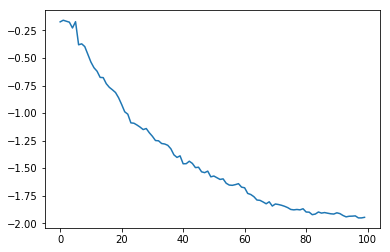

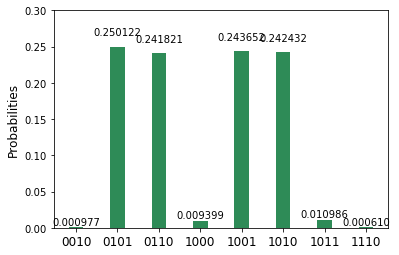

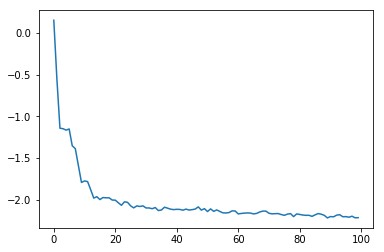

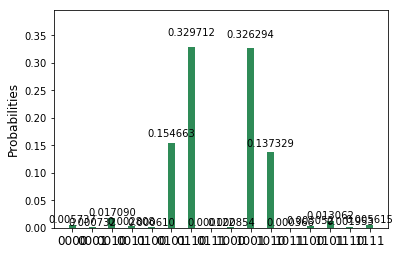

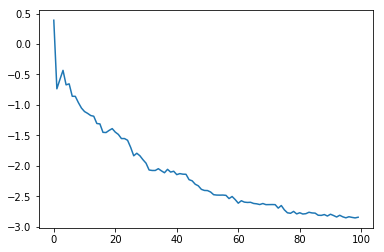

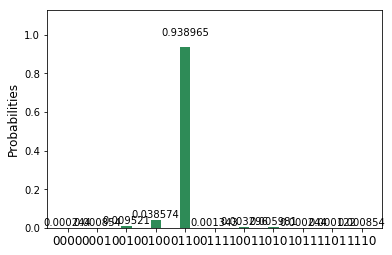

In [16]:
# plotting data
plt.plot(range(max_trials), cost_save[0])
plot_histogram(data_save[0])

plt.plot(range(max_trials), cost_save[1])
plot_histogram(data_save[1])

plt.plot(range(max_trials), cost_save[2])
plot_histogram(data_save[2])

## Four Qubits  (fast)<a id='sectionmaxcutfour'></a>

    Graph:   
             X---X 
             | \ |
             X---X
           
The ground state is degenerate and is either $|100\rangle$, $|010\rangle$ and $|001\rangle$.

In [53]:
# cost function H = alpha_i z_i + beta_ij z_i z_j
n =4
alpha = np.zeros(n)
beta = np.zeros((n, n))
beta[0, 1] = 1
beta[0, 2] = 1
beta[1, 2] = 1
beta[1, 3] = 1
beta[2, 3] = 1

In [ ]:
#Setting up a quantum program and connecting to the Quantum Experience API
Q_program = QuantumProgram()
# set the APIToken and API url
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"])

In [54]:
# Quantum circuit parameters
entangler_map = {0: [1], 1: [2], 2: [3]} # the map of two-qubit gates with control at key and target at values

# Numerical parameters 
SPSA_parameters = np.array([.3,0.602,0,.1,0.101]) #[a, alpha, A, c, gamma]
max_trials = 100;
max_depth = 3

cost, data_save, cost_save = SPSA_Minimization_fast(Q_program, alpha, beta, n, entangler_map, SPSA_parameters, max_trials, max_depth)

print('m = 1 ' + str(cost[0]) + ' m = 2 ' + str(cost[1]) + 'm = 3 ' + str(cost[2]))

trial 0 of 100 cost -0.443144448207
trial 10 of 100 cost -2.06690688808
trial 20 of 100 cost -2.44203589806
trial 30 of 100 cost -2.6697509924
trial 40 of 100 cost -2.79772284857
trial 50 of 100 cost -2.82930402381
trial 60 of 100 cost -2.84525993394
trial 70 of 100 cost -2.91962662926
trial 80 of 100 cost -2.93153505848
trial 90 of 100 cost -2.90795928594
m = 1 -1.96875 m = 2 -2.4296875m = 3 -2.951171875


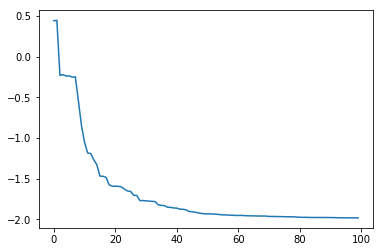

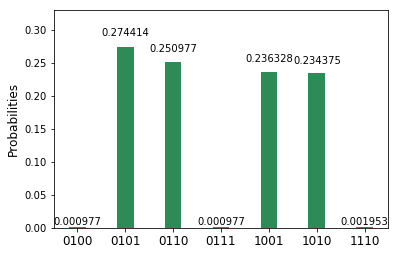

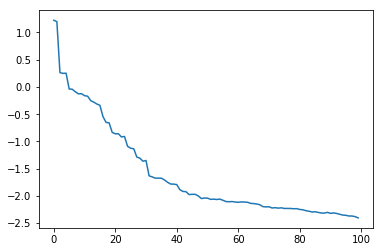

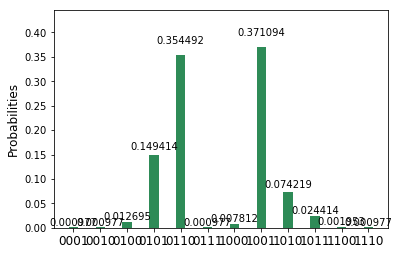

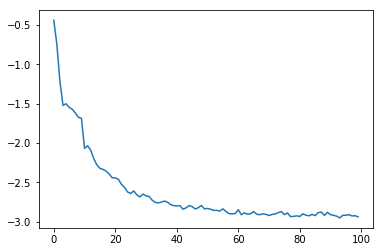

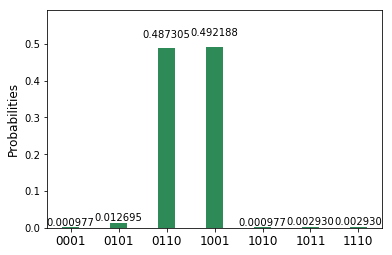

In [55]:
# plotting data
plt.plot(range(max_trials), cost_save[0])
plot_histogram(data_save[0])

plt.plot(range(max_trials), cost_save[1])
plot_histogram(data_save[1])

plt.plot(range(max_trials), cost_save[2])
plot_histogram(data_save[2])

## 10 qubits<a id='sectionmaxcutten'></a>

In [ ]:
n = 10

# cost function H = alpha_i z_i + beta_ij z_i z_j
alpha = np.zeros(n)
beta = np.random.choice([0, 0.5], size=(n,n), p=[1./3, 2./3])

In [ ]:
# quantum circuit parameters
device = 'simulator' # the device to run on
shots = 8192    # the number of shots in the experiment 
entangler_map = {0: [1], 1: [2], 2: [3], 3: [4], 4: [5], 5: [6], 6: [7], 7: [8], 8: [9]} # the map of two-qubit gates with control at key and target at values

# Numerical parameters 
SPSA_parameters = np.array([.3,0.602,0,.1,0.101]) # [a, alpha, A, c, gamma]
max_trials = 100;
theta_depth_1 = np.random.randn(1*n) # initial controls 
theta_depth_2 = np.random.randn(2*n) # initial controls 
theta_depth_3 = np.random.randn(3*n) # initial controls 



trial_circuit_depth_1 =  trial_funtion_optimization(n,1,theta_depth_1,entangler_map) 
trial_circuit_depth_2 =  trial_funtion_optimization(n,2,theta_depth_2,entangler_map) 
trial_circuit_depth_3 =  trial_funtion_optimization(n,3,theta_depth_3,entangler_map) 

program = [trial_circuit_depth_1,trial_circuit_depth_2,trial_circuit_depth_3]
out = run_program(program,api,device,shots,max_credits=3)
results=combine_jobs([out['id']], api, wait=20, timeout=440)  
cost_depth_1 = cost_classical(get_data(results,0),n,alpha,beta)
cost_depth_2 = cost_classical(get_data(results,1),n,alpha,beta)
cost_depth_3 = cost_classical(get_data(results,2),n,alpha,beta)
print('m=1 ' + str(cost_depth_1) + ' m=2 ' + str(cost_depth_2) + 'm=3 ' + str(cost_depth_3))

In [ ]:
# plotting data
plt.plot(range(max_trials), cost_plus_depth_1, range(max_trials), cost_minus_depth_1)
plot_histogram(get_data(results,0),n)
plt.plot(range(max_trials), cost_plus_depth_2, range(max_trials), cost_minus_depth_2)
plot_histogram(get_data(results,1),n)
plt.plot(range(max_trials), cost_plus_depth_3, range(max_trials), cost_minus_depth_3)
plot_histogram(get_data(results,2),n)

In [ ]:
# cost function H = alpha_i z_i + beta_ij z_i z_j
n = 10
alpha = np.zeros(n)
beta = np.random.choice([0, 0.5], size=(n,n), p=[1./3, 2./3])
for i in range(n):
    for j in range(i):
        beta[j,i]=beta[i,j]
for i in range(n):
    beta[i,i]=0;

In [ ]:
# quantum circuit parameters
device = 'simulator' # the device to run on
shots = 8192    # the number of shots in the experiment 
entangler_map = {0: [1], 1: [2], 2: [3], 3: [4], 4: [5], 5: [6], 6: [7], 7: [8], 8: [9]} # the map of two-qubit gates with control at key and target at values

# Numerical parameters 
SPSA_parameters = np.array([.3,0.602,0,.1,0.101]) #[a, alpha, A, c, gamma]
max_trials = 100;
theta_depth_1 = np.random.randn(1*n) # initial controls 
theta_depth_2 = np.random.randn(2*n) # initial controls 
theta_depth_3 = np.random.randn(3*n) # initial controls 

cost_plus_depth_1=np.zeros(max_trials)
cost_minus_depth_1=np.zeros(max_trials)
cost_plus_depth_2=np.zeros(max_trials)
cost_minus_depth_2=np.zeros(max_trials)
cost_plus_depth_3=np.zeros(max_trials)
cost_minus_depth_3=np.zeros(max_trials)

for k in range(max_trials):
    print('trial ' + str(k) + " of " + str(max_trials))
    a_spsa = float(SPSA_parameters[0])/np.power(k+1+SPSA_parameters[2], SPSA_parameters[1])
    c_spsa = float(SPSA_parameters[3])/np.power(k+1, SPSA_parameters[4])

    Delta_depth_1 = 2*np.random.randint(2,size=n*1)-1 # \pm 1 random distribution 
    Delta_depth_2 = 2*np.random.randint(2,size=n*2)-1 # \pm 1 random distribution 
    Delta_depth_3 = 2*np.random.randint(2,size=n*3)-1 # \pm 1 random distribution 
    
    theta_plus_depth_1 = theta_depth_1 + c_spsa*Delta_depth_1
    theta_minus_depth_1 = theta_depth_1 - c_spsa*Delta_depth_1
    theta_plus_depth_2 = theta_depth_2 + c_spsa*Delta_depth_2
    theta_minus_depth_2 = theta_depth_2 - c_spsa*Delta_depth_2
    theta_plus_depth_3 = theta_depth_3 + c_spsa*Delta_depth_3
    theta_minus_depth_3 = theta_depth_3 - c_spsa*Delta_depth_3

    trial_circuit_plus_depth_1 = trial_funtion_optimization(n,1,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_1 = trial_funtion_optimization(n,1,theta_minus_depth_1,entangler_map) 
    trial_circuit_plus_depth_2 = trial_funtion_optimization(n,2,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_2 = trial_funtion_optimization(n,2,theta_minus_depth_2,entangler_map)
    trial_circuit_plus_depth_3 = trial_funtion_optimization(n,3,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_3 = trial_funtion_optimization(n,3,theta_minus_depth_3,entangler_map)
    
    program = [trial_circuit_plus_depth_1,trial_circuit_minus_depth_1,trial_circuit_plus_depth_2
               ,trial_circuit_minus_depth_2,trial_circuit_plus_depth_3,trial_circuit_minus_depth_3]
    out = run_program(program,api,device,shots,max_credits=3)
    results=combine_jobs([out['id']], api, wait=20, timeout=440)
    
    cost_plus_depth_1[k] = cost_classical(get_data(results,0),n,alpha,beta)
    cost_minus_depth_1[k] = cost_classical(get_data(results,1),n,alpha,beta)
    cost_plus_depth_2[k] = cost_classical(get_data(results,2),n,alpha,beta)
    cost_minus_depth_2[k] = cost_classical(get_data(results,3),n,alpha,beta)
    cost_plus_depth_3[k] = cost_classical(get_data(results,4),n,alpha,beta)
    cost_minus_depth_3[k] = cost_classical(get_data(results,5),n,alpha,beta)
    
    g_spsa_depth_1 = (cost_plus_depth_1[k]-cost_minus_depth_1[k])*Delta_depth_1/(2.0*c_spsa)
    g_spsa_depth_2 = (cost_plus_depth_2[k]-cost_minus_depth_2[k])*Delta_depth_2/(2.0*c_spsa)
    g_spsa_depth_3 = (cost_plus_depth_3[k]-cost_minus_depth_3[k])*Delta_depth_3/(2.0*c_spsa)

    theta_depth_1 = theta_depth_1 - a_spsa*g_spsa_depth_1
    theta_depth_2 = theta_depth_2 - a_spsa*g_spsa_depth_2
    theta_depth_3 = theta_depth_3 - a_spsa*g_spsa_depth_3
    print(cost_minus_depth_3[k] +   cost_plus_depth_3[k])

trial_circuit_depth_1 =  trial_funtion_optimization(n,1,theta_depth_1,entangler_map) 
trial_circuit_depth_2 =  trial_funtion_optimization(n,2,theta_depth_2,entangler_map) 
trial_circuit_depth_3 =  trial_funtion_optimization(n,3,theta_depth_3,entangler_map) 

program = [trial_circuit_depth_1,trial_circuit_depth_2,trial_circuit_depth_3]
out = run_program(program,api,device,shots,max_credits=3)
results=combine_jobs([out['id']], api, wait=20, timeout=440)  
cost_depth_1 = cost_classical(get_data(results,0),n,alpha,beta)
cost_depth_2 = cost_classical(get_data(results,1),n,alpha,beta)
cost_depth_3 = cost_classical(get_data(results,2),n,alpha,beta)
print('m=1 ' + str(cost_depth_1) + ' m=2 ' + str(cost_depth_2) + 'm=3 ' + str(cost_depth_3))

In [ ]:
# plotting data
plt.plot(range(max_trials), cost_plus_depth_1, range(max_trials), cost_minus_depth_1)
plot_histogram(get_data(results,0),n)
plt.plot(range(max_trials), cost_plus_depth_2, range(max_trials), cost_minus_depth_2)
plot_histogram(get_data(results,1),n)
plt.plot(range(max_trials), cost_plus_depth_3, range(max_trials), cost_minus_depth_3)
plot_histogram(get_data(results,2),n)

## Max Cut (DONNA) 

In [ ]:
# cost function H = alpha_i z_i + beta_ij z_i z_j
n = 6
alpha = np.zeros(n)
beta = np.zeros((n, n))
beta[0, 1] = 93/2
beta[0, 4] = 17/2
beta[0, 5] = 51/2
beta[1, 0] = 93/2
beta[1, 5] = 13/2
beta[1, 2] = 77/2
beta[2, 1] = 77/2
beta[2, 3] = 31/2
beta[2, 5] = 23/2
beta[3,2] = 31/2
beta[3,4] = 7/2
beta[3,5] = 46/2
beta[4,3] = 7/2
beta[4,5] = 65/2
beta[4,0] = 17/2

beta[5,0] = 51/2
beta[5,1] = 13/2
beta[5,2] = 23/2
beta[5,3] = 46/2
beta[5,4] = 65/2

In [ ]:
# quantum circuit parameters
device = 'simulator' # the device to run on
shots = 8192    # the number of shots in the experiment 
entangler_map = {0: [1], 1: [2], 2: [3], 3: [4]} # the map of two-qubit gates with control at key and target at values

# Numerical parameters 
SPSA_parameters = np.array([3,0.602,0,.3,0.101]) #[a, alpha, A, c, gamma]
max_trials = 100;
theta_depth_1 = np.random.randn(1*n) # initial controls 
theta_depth_2 = np.random.randn(2*n) # initial controls 
theta_depth_3 = np.random.randn(3*n) # initial controls 

cost_plus_depth_1=np.zeros(max_trials)
cost_minus_depth_1=np.zeros(max_trials)
cost_plus_depth_2=np.zeros(max_trials)
cost_minus_depth_2=np.zeros(max_trials)
cost_plus_depth_3=np.zeros(max_trials)
cost_minus_depth_3=np.zeros(max_trials)

for k in range(max_trials):
    print('trial ' + str(k) + " of " + str(max_trials))
    a_spsa = float(SPSA_parameters[0])/np.power(k+1+SPSA_parameters[2], SPSA_parameters[1])
    c_spsa = float(SPSA_parameters[3])/np.power(k+1, SPSA_parameters[4])

    Delta_depth_1 = 2*np.random.randint(2,size=n*1)-1 # \pm 1 random distribution 
    Delta_depth_2 = 2*np.random.randint(2,size=n*2)-1 # \pm 1 random distribution 
    Delta_depth_3 = 2*np.random.randint(2,size=n*3)-1 # \pm 1 random distribution 
    
    theta_plus_depth_1 = theta_depth_1 + c_spsa*Delta_depth_1
    theta_minus_depth_1 = theta_depth_1 - c_spsa*Delta_depth_1
    theta_plus_depth_2 = theta_depth_2 + c_spsa*Delta_depth_2
    theta_minus_depth_2 = theta_depth_2 - c_spsa*Delta_depth_2
    theta_plus_depth_3 = theta_depth_3 + c_spsa*Delta_depth_3
    theta_minus_depth_3 = theta_depth_3 - c_spsa*Delta_depth_3

    trial_circuit_plus_depth_1 = trial_funtion_optimization(n,1,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_1 = trial_funtion_optimization(n,1,theta_minus_depth_1,entangler_map) 
    trial_circuit_plus_depth_2 = trial_funtion_optimization(n,2,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_2 = trial_funtion_optimization(n,2,theta_minus_depth_2,entangler_map)
    trial_circuit_plus_depth_3 = trial_funtion_optimization(n,3,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_3 = trial_funtion_optimization(n,3,theta_minus_depth_3,entangler_map)
    
    program = [trial_circuit_plus_depth_1,trial_circuit_minus_depth_1,trial_circuit_plus_depth_2
               ,trial_circuit_minus_depth_2,trial_circuit_plus_depth_3,trial_circuit_minus_depth_3]
    out = run_program(program,api,device,shots,max_credits=3)
    results=combine_jobs([out['id']], api, wait=20, timeout=440)
    
    cost_plus_depth_1[k] = cost_classical(get_data(results,0),n,alpha,beta)
    cost_minus_depth_1[k] = cost_classical(get_data(results,1),n,alpha,beta)
    cost_plus_depth_2[k] = cost_classical(get_data(results,2),n,alpha,beta)
    cost_minus_depth_2[k] = cost_classical(get_data(results,3),n,alpha,beta)
    cost_plus_depth_3[k] = cost_classical(get_data(results,4),n,alpha,beta)
    cost_minus_depth_3[k] = cost_classical(get_data(results,5),n,alpha,beta)
    
    g_spsa_depth_1 = (cost_plus_depth_1[k]-cost_minus_depth_1[k])*Delta_depth_1/(2.0*c_spsa)
    g_spsa_depth_2 = (cost_plus_depth_2[k]-cost_minus_depth_2[k])*Delta_depth_2/(2.0*c_spsa)
    g_spsa_depth_3 = (cost_plus_depth_3[k]-cost_minus_depth_3[k])*Delta_depth_3/(2.0*c_spsa)

    theta_depth_1 = theta_depth_1 - a_spsa*g_spsa_depth_1
    theta_depth_2 = theta_depth_2 - a_spsa*g_spsa_depth_2
    theta_depth_3 = theta_depth_3 - a_spsa*g_spsa_depth_3

trial_circuit_depth_1 =  trial_funtion_optimization(n,1,theta_depth_1,entangler_map) 
trial_circuit_depth_2 =  trial_funtion_optimization(n,2,theta_depth_2,entangler_map) 
trial_circuit_depth_3 =  trial_funtion_optimization(n,3,theta_depth_3,entangler_map) 

program = [trial_circuit_depth_1,trial_circuit_depth_2,trial_circuit_depth_3]
out = run_program(program,api,device,shots,max_credits=3)
results=combine_jobs([out['id']], api, wait=20, timeout=440)  
cost_depth_1 = cost_classical(get_data(results,0),n,alpha,beta)
cost_depth_2 = cost_classical(get_data(results,1),n,alpha,beta)
cost_depth_3 = cost_classical(get_data(results,2),n,alpha,beta)
print('m=1 ' + str(cost_depth_1) + ' m=2 ' + str(cost_depth_2) + 'm=3 ' + str(cost_depth_3))

In [ ]:
# plotting data
plt.plot(range(max_trials), cost_plus_depth_1, range(max_trials), cost_minus_depth_1)
plot_histogram(get_data(results,0),n)
plt.plot(range(max_trials), cost_plus_depth_2, range(max_trials), cost_minus_depth_2)
plot_histogram(get_data(results,1),n)
plt.plot(range(max_trials), cost_plus_depth_3, range(max_trials), cost_minus_depth_3)
plot_histogram(get_data(results,2),n)

## REAL

In [ ]:
# quantum circuit parameters
device = 'real' # the device to run on
shots = 8192    # the number of shots in the experiment
n = 2
entangler_map = {0: [1]} # the map of two-qubit gates with control at key and target at values

# Numerical parameters 
SPSA_parameters = np.array([.3,0.602,0,.3,0.101]) #[a, alpha, A, c, gamma]
max_trials = 100;
theta_depth_1 = np.random.randn(1*n) # initial controls 
theta_depth_2 = np.random.randn(2*n) # initial controls 
theta_depth_3 = np.random.randn(3*n) # initial controls 

cost_plus_depth_1=np.zeros(max_trials)
cost_minus_depth_1=np.zeros(max_trials)
cost_plus_depth_2=np.zeros(max_trials)
cost_minus_depth_2=np.zeros(max_trials)
cost_plus_depth_3=np.zeros(max_trials)
cost_minus_depth_3=np.zeros(max_trials)

for k in range(max_trials):
    print('trial ' + str(k) + " of " + str(max_trials))
    a_spsa = float(SPSA_parameters[0])/np.power(k+1+SPSA_parameters[2], SPSA_parameters[1])
    c_spsa = float(SPSA_parameters[3])/np.power(k+1, SPSA_parameters[4])

    Delta_depth_1 = 2*np.random.randint(2,size=n*1)-1 # \pm 1 random distribution 
    Delta_depth_2 = 2*np.random.randint(2,size=n*2)-1 # \pm 1 random distribution 
    Delta_depth_3 = 2*np.random.randint(2,size=n*3)-1 # \pm 1 random distribution 
    
    theta_plus_depth_1 = theta_depth_1 + c_spsa*Delta_depth_1
    theta_minus_depth_1 = theta_depth_1 - c_spsa*Delta_depth_1
    theta_plus_depth_2 = theta_depth_2 + c_spsa*Delta_depth_2
    theta_minus_depth_2 = theta_depth_2 - c_spsa*Delta_depth_2
    theta_plus_depth_3 = theta_depth_3 + c_spsa*Delta_depth_3
    theta_minus_depth_3 = theta_depth_3 - c_spsa*Delta_depth_3

    trial_circuit_plus_depth_1 = trial_funtion_optimization(n,1,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_1 = trial_funtion_optimization(n,1,theta_minus_depth_1,entangler_map) 
    trial_circuit_plus_depth_2 = trial_funtion_optimization(n,2,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_2 = trial_funtion_optimization(n,2,theta_minus_depth_2,entangler_map)
    trial_circuit_plus_depth_3 = trial_funtion_optimization(n,3,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_3 = trial_funtion_optimization(n,3,theta_minus_depth_3,entangler_map)
    
    program = [trial_circuit_plus_depth_1,trial_circuit_minus_depth_1,trial_circuit_plus_depth_2
               ,trial_circuit_minus_depth_2,trial_circuit_plus_depth_3,trial_circuit_minus_depth_3]
    out = run_program(program,api,device,shots,max_credits=5)
    results=combine_jobs([out['id']], api, wait=20, timeout=480)
    
    cost_plus_depth_1[k] = cost_classical(get_data(results,0),n,alpha,beta)
    cost_minus_depth_1[k] = cost_classical(get_data(results,1),n,alpha,beta)
    cost_plus_depth_2[k] = cost_classical(get_data(results,2),n,alpha,beta)
    cost_minus_depth_2[k] = cost_classical(get_data(results,3),n,alpha,beta)
    cost_plus_depth_3[k] = cost_classical(get_data(results,4),n,alpha,beta)
    cost_minus_depth_3[k] = cost_classical(get_data(results,5),n,alpha,beta)
    
    g_spsa_depth_1 = (cost_plus_depth_1[k]-cost_minus_depth_1[k])*Delta_depth_1/(2.0*c_spsa)
    g_spsa_depth_2 = (cost_plus_depth_2[k]-cost_minus_depth_2[k])*Delta_depth_2/(2.0*c_spsa)
    g_spsa_depth_3 = (cost_plus_depth_3[k]-cost_minus_depth_3[k])*Delta_depth_3/(2.0*c_spsa)

    theta_depth_1 = theta_depth_1 - a_spsa*g_spsa_depth_1
    theta_depth_2 = theta_depth_2 - a_spsa*g_spsa_depth_2
    theta_depth_3 = theta_depth_3 - a_spsa*g_spsa_depth_3

trial_circuit_depth_1 =  trial_funtion_optimization(n,1,theta_depth_1,entangler_map) 
trial_circuit_depth_2 =  trial_funtion_optimization(n,2,theta_depth_2,entangler_map) 
trial_circuit_depth_3 =  trial_funtion_optimization(n,3,theta_depth_3,entangler_map) 

program = [trial_circuit_depth_1,trial_circuit_depth_2,trial_circuit_depth_3]
out = run_program(program,api,device,shots,max_credits=5)
results=combine_jobs([out['id']], api, wait=20, timeout=240)  
cost_depth_1 = cost_classical(get_data(results,0),n,alpha,beta)
cost_depth_2 = cost_classical(get_data(results,1),n,alpha,beta)
cost_depth_3 = cost_classical(get_data(results,2),n,alpha,beta)
print('m=1 ' + str(cost_depth_1) + ' m=2 ' + str(cost_depth_2) + 'm=3 ' + str(cost_depth_3))

In [ ]:
# plotting data
plt.plot(range(max_trials), cost_plus_depth_1, range(max_trials), cost_minus_depth_1)
plot_histogram(get_data(results,0),n)
plt.plot(range(max_trials), cost_plus_depth_2, range(max_trials), cost_minus_depth_2)
plot_histogram(get_data(results,1),n)
plt.plot(range(max_trials), cost_plus_depth_3, range(max_trials), cost_minus_depth_3)
plot_histogram(get_data(results,2),n)